In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer

# EDA

In [2]:
data = pd.read_csv('kiva_train.csv')

In [3]:
data.head()

,id,country,en,gender,loan_amount,nonpayment,sector,status
0,1,Ecuador,<h4>Business Description</h4> \r\n <p> Don Mau...,M,825,lender,Food,1
1,2,Dominican Republic,Rosa Iris is a brilliant entrepreneur who sell...,F,450,partner,Retail,0
2,3,Kenya,Sirote is married with six children. Two of he...,F,600,lender,Agriculture,1
3,4,Kenya,David Mwangi Kimani is 33 years old and marri...,M,650,lender,Food,1
4,5,Dominican Republic,Nilda is a very persistent woman who has learn...,F,325,partner,Food,0


In [4]:
data.shape

(5454, 8)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5454 entries, 0 to 5453
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           5454 non-null   int64 
 1   country      5454 non-null   object
 2   en           5454 non-null   object
 3   gender       5454 non-null   object
 4   loan_amount  5454 non-null   int64 
 5   nonpayment   5454 non-null   object
 6   sector       5454 non-null   object
 7   status       5454 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 341.0+ KB


In [6]:
data.dtypes

id              int64
country        object
en             object
gender         object
loan_amount     int64
nonpayment     object
sector         object
status          int64
dtype: object

In [7]:
data.isnull().sum()

id             0
country        0
en             0
gender         0
loan_amount    0
nonpayment     0
sector         0
status         0
dtype: int64

<Axes: xlabel='status'>

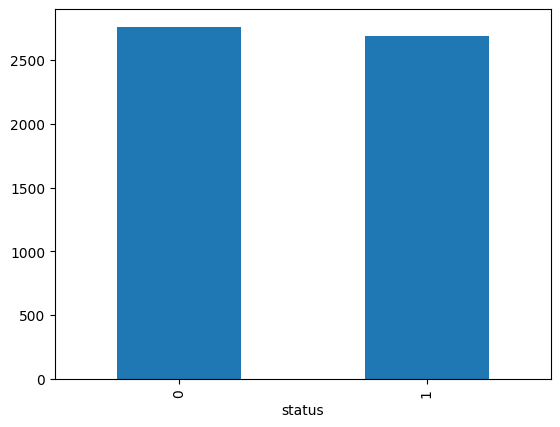

In [8]:
data['status'].value_counts().plot.bar()

<Axes: xlabel='country'>

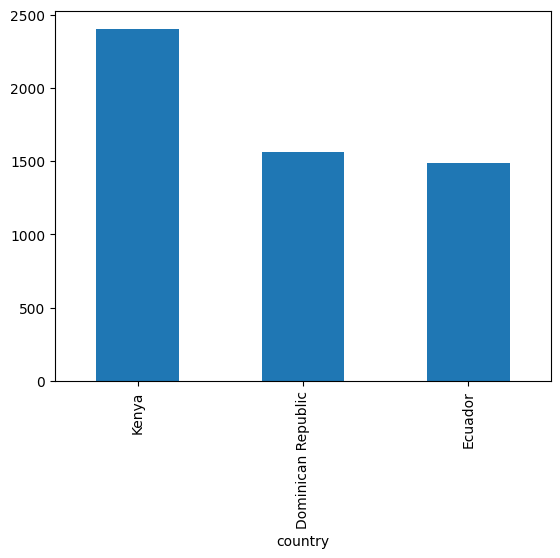

In [9]:
data['country'].value_counts().plot.bar()

<Axes: xlabel='sector'>

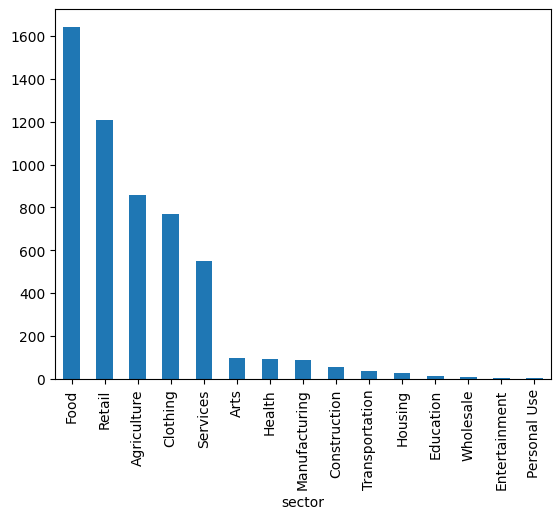

In [10]:
data['sector'].value_counts().plot.bar()

<Axes: xlabel='gender'>

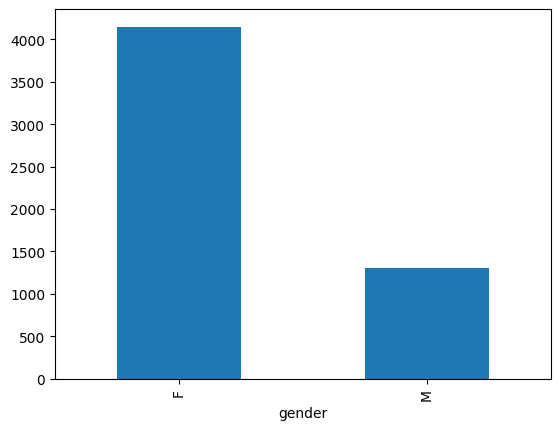

In [11]:
data['gender'].value_counts().plot.bar()

<Axes: >

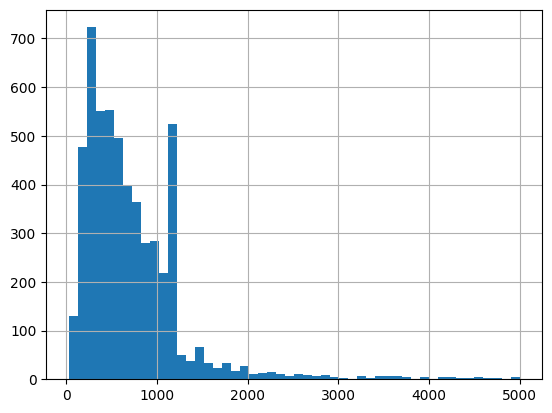

In [12]:
data['loan_amount'].hist(bins=50)

In [13]:
# mean and std
print(data['loan_amount'].mean())
print(data['loan_amount'].std())

718.2178217821782
587.2376139713296


# 1. Without `en` column

In [14]:
# Load the data from CSV files
data_train = pd.read_csv('kiva_train.csv')
data_test = pd.read_csv('kiva_test.csv')
test_labels = pd.read_csv('kiva_test_labels.csv')

In [15]:
# Define X and y for the training set
X_train = data_train.drop(columns=['status', 'en', 'id'])
y_train = data_train['status']

In [16]:
X_train

,country,gender,loan_amount,nonpayment,sector
0,Ecuador,M,825,lender,Food
1,Dominican Republic,F,450,partner,Retail
2,Kenya,F,600,lender,Agriculture
3,Kenya,M,650,lender,Food
4,Dominican Republic,F,325,partner,Food
...,...,...,...,...,...
5449,Kenya,F,450,lender,Agriculture
5450,Ecuador,F,475,partner,Retail
5451,Kenya,M,200,lender,Food
5452,Ecuador,M,300,lender,Food


In [17]:
# Define X for the test set (no 'status' column here)
X_test = data_test.drop(columns=['en', 'id'])

In [18]:
X_test

,country,gender,loan_amount,nonpayment,sector
0,Kenya,M,450,partner,Agriculture
1,Ecuador,F,650,lender,Retail
2,Ecuador,M,950,lender,Agriculture
3,Kenya,F,675,lender,Services
4,Ecuador,F,375,partner,Food
...,...,...,...,...,...
1359,Kenya,F,1200,lender,Services
1360,Dominican Republic,F,375,partner,Food
1361,Kenya,F,4000,partner,Food
1362,Kenya,F,500,lender,Food


In [19]:
# Define the categorical columns to be one-hot encoded
categorical_cols = ['country', 'gender', 'nonpayment', 'sector']

# Set up the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_cols)
    ])

# Create a pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', LogisticRegression())])

In [20]:
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['country', 'gender',
                                                   'nonpayment', 'sector'])])),
                ('classifier', LogisticRegression())])

In [21]:
# Train the model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['country', 'gender',
                                                   'nonpayment', 'sector'])])),
                ('classifier', LogisticRegression())])

In [22]:
# Predict probabilities on the test set
y_pred_prob = pipeline.predict_proba(X_test)[:, 1]

In [23]:
y_pred_prob

array([0.12384792, 0.79418202, 0.56024544, ..., 0.26675343, 0.93715817,
       0.56024544])

In [24]:
# Create the DataFrame
kaggle_submission1 = pd.DataFrame({
    'id': range(5455, 5455 + len(y_pred_prob)),
    'status': y_pred_prob
})

In [25]:
# store csv
kaggle_submission1.to_csv('kaggle_submission1.csv', index=False)

In [26]:
# Load the actual status labels for the test set
y_test = test_labels['status']

In [27]:
y_test

0       0
1       1
2       1
3       1
4       0
       ..
1359    1
1360    0
1361    0
1362    1
1363    0
Name: status, Length: 1364, dtype: int64

In [28]:
# Calculate AUC
auc_without_en = roc_auc_score(y_test, y_pred_prob)
print(f'AUC without en column: {auc_without_en}')

AUC without en column: 0.8900564033863535


# 2. With `en` column

In [29]:
# Load the data from CSV files
data_train = pd.read_csv('kiva_train.csv')
data_test = pd.read_csv('kiva_test.csv')
test_labels = pd.read_csv('kiva_test_labels.csv')

In [30]:
# Define X and y for the training set
X_train = data_train.drop(columns=['status', 'id'])
y_train = data_train['status']

In [31]:
X_train

,country,en,gender,loan_amount,nonpayment,sector
0,Ecuador,<h4>Business Description</h4> \r\n <p> Don Mau...,M,825,lender,Food
1,Dominican Republic,Rosa Iris is a brilliant entrepreneur who sell...,F,450,partner,Retail
2,Kenya,Sirote is married with six children. Two of he...,F,600,lender,Agriculture
3,Kenya,David Mwangi Kimani is 33 years old and marri...,M,650,lender,Food
4,Dominican Republic,Nilda is a very persistent woman who has learn...,F,325,partner,Food
...,...,...,...,...,...,...
5449,Kenya,"Mary Kanyi is married with five children, all ...",F,450,lender,Agriculture
5450,Ecuador,<p>Irene has a general store where she sells c...,F,475,partner,Retail
5451,Kenya,Kevin is a 19 year old orphan who has lost his...,M,200,lender,Food
5452,Ecuador,<p>Business Description</p>\r\n<p> For the las...,M,300,lender,Food


In [32]:
# Define X for the test set (no 'status' column here)
X_test = data_test.drop(columns=['id'])

In [33]:
X_test

,country,en,gender,loan_amount,nonpayment,sector
0,Kenya,Danson has four children--two whom are adults ...,M,450,partner,Agriculture
1,Ecuador,Description of the Business<p>\r\n\r\nBlanca h...,F,650,lender,Retail
2,Ecuador,<p>Julio has a small farm where he raises chic...,M,950,lender,Agriculture
3,Kenya,Elizabeth was born forty-one years ago in Ngon...,F,675,lender,Services
4,Ecuador,Juanita buys green bananas and lets them rippe...,F,375,partner,Food
...,...,...,...,...,...,...
1359,Kenya,Rachael is a mother of 2 children who are in p...,F,1200,lender,Services
1360,Dominican Republic,Trinidad wants to start a new cafeteria. She p...,F,375,partner,Food
1361,Kenya,The Chanuka support group was formed on 1st Ma...,F,4000,partner,Food
1362,Kenya,Jane Wambui Munene is 45 years old and a singl...,F,500,lender,Food


In [34]:
# Define the categorical columns to be one-hot encoded
categorical_cols = ['country', 'gender', 'nonpayment', 'sector']

# Set up the text preprocessor for the 'en' column
text_preprocessor = Pipeline([
    ('vectorizer', CountVectorizer())
])

# Redefine the preprocessor to include the 'en' column processing
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_cols),
        ('text', text_preprocessor, 'en')
    ])

# Create a pipeline for the second model
pipeline_with_en = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('classifier', LogisticRegression(max_iter=100))])

In [35]:
pipeline_with_en

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['country', 'gender',
                                                   'nonpayment', 'sector']),
                                                 ('text',
                                                  Pipeline(steps=[('vectorizer',
                                                                   CountVectorizer())]),
                                                  'en')])),
                ('classifier', LogisticRegression())])

In [36]:
# Train the second model
pipeline_with_en.fit(X_train, y_train)

c:\Users\owner\anaconda3\envs\mmai891\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['country', 'gender',
                                                   'nonpayment', 'sector']),
                                                 ('text',
                                                  Pipeline(steps=[('vectorizer',
                                                                   CountVectorizer())]),
                                                  'en')])),
                ('classifier', LogisticRegression())])

In [37]:
# Predict probabilities on the test set for the second model
y_pred_prob_with_en = pipeline_with_en.predict_proba(X_test)[:, 1]

In [38]:
y_pred_prob_with_en

array([6.57885665e-02, 9.79286707e-01, 3.66063384e-01, ...,
       3.91896400e-08, 9.99997757e-01, 2.44582150e-04])

In [39]:
# Create the DataFrame
kaggle_submission2 = pd.DataFrame({
    'id': range(5455, 5455 + len(y_pred_prob_with_en)),
    'status': y_pred_prob_with_en
})

In [40]:
kaggle_submission2

,id,status
0,5455,6.578857e-02
1,5456,9.792867e-01
2,5457,3.660634e-01
3,5458,9.232212e-01
4,5459,7.309865e-05
...,...,...
1359,6814,9.997975e-01
1360,6815,2.431184e-03
1361,6816,3.918964e-08
1362,6817,9.999978e-01


In [41]:
# Calculate AUC for the second model
auc_with_en = roc_auc_score(y_test, y_pred_prob_with_en)
print(f'AUC with en column: {auc_with_en}')

AUC with en column: 0.9797287562655497
